In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from matplotlib.pyplot import cm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, train_test_split
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

In [2]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
# Set GPU as the default device
tf.config.experimental.set_visible_devices(tf.config.experimental.list_physical_devices('GPU')[0], 'GPU')

# Verify that GPU is the default device
print("Default Device: ", tf.test.gpu_device_name())

Default Device:  /device:GPU:0


In [6]:
!unzip drive/MyDrive/project2.zip

Archive:  drive/MyDrive/project2.zip
   creating: project2/
  inflating: project2/corridor_both_directions_revised.txt  
  inflating: project2/corridor_both_directions_revised_dataset.txt  
  inflating: project2/data_preprocessing.py  
  inflating: project2/left_turn_revised.txt  
  inflating: project2/left_turn_revised_dataset.txt  
  inflating: project2/supermarket_revised.txt  
  inflating: project2/supermarket_revised_dataset.txt  


In [7]:
supermarket_data = pd.read_csv("./project2/supermarket_revised.txt", sep=" ")
supermarket_data

,timeStep,pedestrianId,x,y
0,1,1,47.901000,12.101000
1,1,2,48.303000,12.101000
2,1,3,48.705000,12.101000
3,1,4,49.107000,12.101000
4,1,5,47.901000,12.503000
...,...,...,...,...
57504,575,12,5.280909,42.452165
57505,575,15,14.311389,46.676385
57506,575,22,3.080939,37.803208
57507,575,36,14.606136,33.973301


In [8]:
from preprocessing import *
from creating_preprocessing_data import *

In [9]:
from scipy.spatial import distance 

In [10]:
def remove_diagonal(A):
    return A[~np.eye(A.shape[0],dtype=bool)].reshape(A.shape[0],-1)

In [11]:
NO_NEIGHBORS = 5
TIMESTEP_LENGTH = 0.4

dic = {
    'timestep': [],
    'pid': [],
    'pos': [],
    'mean_spacing': [],
    'speed': [],
    'knn': []
}

for timestep in range(1, supermarket_data.timeStep.max()):
    frame = supermarket_data[supermarket_data.timeStep == timestep]
    next_frame = supermarket_data[supermarket_data.timeStep == timestep + 1]

    frame = frame[frame['pedestrianId'].isin(next_frame['pedestrianId'])]
    next_frame = next_frame[next_frame['pedestrianId'].isin(frame['pedestrianId'])]

    if len(frame) <= NO_NEIGHBORS:
        continue

    pos = frame[['x', 'y']].to_numpy()
    next_pos = next_frame[['x', 'y']].to_numpy()

    dist = distance.squareform(distance.pdist(pos))
    dist = remove_diagonal(dist)[:, :NO_NEIGHBORS]

    knn = np.argsort(dist, axis=1)

    dic['timestep'] += frame.timeStep.to_list()
    dic['pid'] += frame.pedestrianId.to_list()
    dic['pos'] += pos.tolist()
    dic['mean_spacing'] += dist.mean(axis = 1).tolist()
    dic['speed'] += (np.linalg.norm(next_pos - pos, axis=1) / TIMESTEP_LENGTH).tolist() 
    dic['knn'] += (pos[knn] - pos[:, np.newaxis]).tolist()

In [12]:
supermarket_temp = pd.DataFrame(dic)
# df2.to_csv('data/corridor_both_directions.csv', sep=' ', index=False)
supermarket_temp

,timestep,pid,pos,mean_spacing,speed,knn
0,1,1,"[47.901, 12.101]",0.676503,0.000000,"[[0.0, 0.0], [1.206000000000003, 0.0], [0.0, 0..."
1,1,2,"[48.303, 12.101]",0.515703,0.000000,"[[-0.4019999999999939, 0.0], [-0.4019999999999..."
2,1,3,"[48.705000000000005, 12.101]",0.615083,0.000000,"[[0.0, 0.0], [-0.40200000000000813, 0.0], [-0...."
3,1,4,"[49.107000000000006, 12.101]",0.916427,0.000000,"[[-0.402000000000001, 0.0], [-0.80400000000000..."
4,1,5,"[47.901, 12.503]",0.708530,0.000000,"[[0.0, 0.0], [0.0, -0.40199999999999925], [0.4..."
...,...,...,...,...,...,...
57384,574,12,"[5.302594585357524, 42.70988354137281]",6.005472,0.646573,"[[-1.0522869318972932, -0.7842550113720463], [..."
57385,574,15,"[14.655908008961523, 46.48356320509092]",10.424828,0.987020,"[[-6.761958977864826, 0.8054588317573916], [9...."
57386,574,22,"[3.4752077814825366, 37.7505827854045]",8.811933,0.994412,"[[0.9006879848869724, 3.348203526754112], [-0...."
57387,574,36,"[14.726751625899889, 33.603239248824664]",14.114622,0.973055,"[[-10.35085585953038, 7.4955470633339445], [-1..."


In [13]:
supermarket_processed = convert_df(supermarket_temp)
supermarket_processed

,timestep,pid,speed,mean_spacing,ID,X,Y,0,1,2,3,4,5,6,7,8,9
0,1,1,0.000000,0.676503,1,47.901000,12.101000,0.000000,0.000000,1.206000,0.000000,0.000000,0.402000,0.402000,0.000000,0.804000,0.000000
1,1,2,0.000000,0.515703,2,48.303000,12.101000,-0.402000,0.000000,-0.402000,0.402000,0.000000,0.000000,0.804000,0.000000,0.402000,0.000000
2,1,3,0.000000,0.615083,3,48.705000,12.101000,0.000000,0.000000,-0.402000,0.000000,-0.804000,0.402000,-0.804000,0.000000,0.402000,0.000000
3,1,4,0.000000,0.916427,4,49.107000,12.101000,-0.402000,0.000000,-0.804000,0.000000,-1.206000,0.402000,-1.206000,0.000000,0.000000,0.000000
4,1,5,0.000000,0.708530,5,47.901000,12.503000,0.000000,0.000000,0.000000,-0.402000,0.402000,-0.402000,0.804000,-0.402000,1.206000,-0.402000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57384,574,12,0.646573,6.005472,12,5.302595,42.709884,-1.052287,-0.784255,-0.926699,-1.611097,-2.597942,-0.928790,2.591354,4.579138,18.715576,2.125383
57385,574,15,0.987020,10.424828,15,14.655908,46.483563,-6.761959,0.805459,9.362262,-1.648296,-10.405600,-4.557935,-10.280012,-5.384777,-11.951255,-4.702470
57386,574,22,0.994412,8.811933,22,3.475208,37.750583,0.900688,3.348204,-0.770555,4.030511,0.775100,4.175046,4.418741,9.538439,20.542962,7.084684
57387,574,36,0.973055,14.114622,36,14.726752,33.603239,-10.350856,7.495547,-10.476444,8.322389,-12.022099,8.177854,9.291419,11.232027,-6.832803,13.685783


In [14]:
print(supermarket_processed.shape)

(57389, 17)


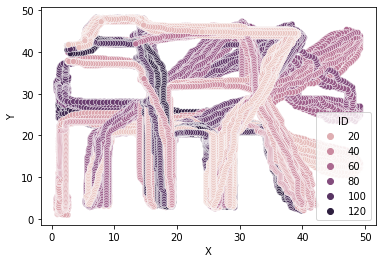

In [15]:
sns.scatterplot(x="X", y="Y", hue="ID", data=supermarket_processed)

In [16]:
supermarket_processed.describe()

,timestep,pid,speed,mean_spacing,ID,X,Y,0,1,2,3,4,5,6,7,8,9
count,57389.000000,57389.000000,57389.000000,57389.000000,57389.000000,57389.000000,57389.000000,57389.000000,57389.000000,57389.000000,57389.000000,57389.000000,57389.000000,57389.000000,57389.000000,57389.000000,57389.000000
mean,244.376658,59.509558,0.939021,17.607229,59.509558,21.723142,23.818771,0.890885,-0.567486,1.014190,-0.988006,1.160341,-2.227029,0.951330,-2.427573,1.212488,-2.959302
std,145.745074,36.160333,0.278067,9.794459,36.160333,10.676517,12.382061,13.159666,10.107461,13.952728,10.909760,15.494704,12.750374,16.674591,15.335496,17.894329,16.530336
min,1.000000,1.000000,0.000000,0.515703,1.000000,0.701000,0.937824,-35.200476,-32.423068,-35.683316,-34.476424,-35.308322,-41.256948,-35.533905,-43.195034,-35.600231,-43.520287
25%,120.000000,27.000000,0.921648,9.679840,27.000000,14.603106,14.323205,-4.530341,-5.470895,-5.588607,-7.125127,-7.583362,-10.517752,-10.025160,-13.349172,-11.825820,-14.771813
50%,240.000000,58.000000,0.994794,15.929666,58.000000,19.504809,21.617843,0.110464,-0.170776,0.182560,-0.336945,0.917948,-1.079496,0.535561,-2.047792,0.811942,-2.634884
75%,360.000000,93.000000,1.000000,23.856262,93.000000,29.484985,33.561064,7.762825,4.168579,9.116387,4.981993,10.946347,5.714546,12.739343,8.019583,14.967628,8.570654
max,574.000000,120.000000,1.999384,51.921816,120.000000,49.240014,48.368335,47.200000,43.488597,47.200000,43.601041,47.602000,43.608017,48.004000,43.449150,48.406000,44.807544


In [17]:
print(supermarket_processed.dtypes)

timestep          int64
pid               int64
speed           float64
mean_spacing    float64
ID                int64
X               float64
Y               float64
0               float64
1               float64
2               float64
3               float64
4               float64
5               float64
6               float64
7               float64
8               float64
9               float64
dtype: object


In [18]:
X = supermarket_processed[["timestep", "X", "Y", "0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "mean_spacing"]]
y = supermarket_processed["speed"]

X

,timestep,X,Y,0,1,2,3,4,5,6,7,8,9,mean_spacing
0,1,47.901000,12.101000,0.000000,0.000000,1.206000,0.000000,0.000000,0.402000,0.402000,0.000000,0.804000,0.000000,0.676503
1,1,48.303000,12.101000,-0.402000,0.000000,-0.402000,0.402000,0.000000,0.000000,0.804000,0.000000,0.402000,0.000000,0.515703
2,1,48.705000,12.101000,0.000000,0.000000,-0.402000,0.000000,-0.804000,0.402000,-0.804000,0.000000,0.402000,0.000000,0.615083
3,1,49.107000,12.101000,-0.402000,0.000000,-0.804000,0.000000,-1.206000,0.402000,-1.206000,0.000000,0.000000,0.000000,0.916427
4,1,47.901000,12.503000,0.000000,0.000000,0.000000,-0.402000,0.402000,-0.402000,0.804000,-0.402000,1.206000,-0.402000,0.708530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57384,574,5.302595,42.709884,-1.052287,-0.784255,-0.926699,-1.611097,-2.597942,-0.928790,2.591354,4.579138,18.715576,2.125383,6.005472
57385,574,14.655908,46.483563,-6.761959,0.805459,9.362262,-1.648296,-10.405600,-4.557935,-10.280012,-5.384777,-11.951255,-4.702470,10.424828
57386,574,3.475208,37.750583,0.900688,3.348204,-0.770555,4.030511,0.775100,4.175046,4.418741,9.538439,20.542962,7.084684,8.811933
57387,574,14.726752,33.603239,-10.350856,7.495547,-10.476444,8.322389,-12.022099,8.177854,9.291419,11.232027,-6.832803,13.685783,14.114622


In [19]:
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import resample
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score ,KFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline

Average MSE: 0.7595652292512044
Test MSE: 0.7699797733973179


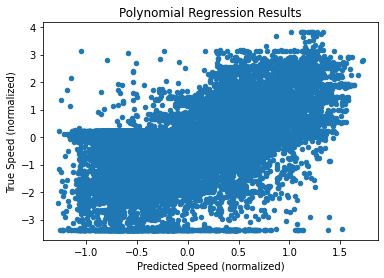

In [20]:
# Split the data into features (X) and target (y)
X = supermarket_processed[["timestep", "X", "Y", "0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "mean_spacing"]]
y = supermarket_processed["speed"]

# Load the data
scaler_X = StandardScaler()

# Fit the scaler on X
scaler_X.fit(X)

# Transform X
X = scaler_X.transform(X)

# Initialize the scaler for y
scaler_y = StandardScaler()

# Fit the scaler on y
scaler_y.fit(y.values.reshape(-1, 1))

# Transform y
y = scaler_y.transform(y.values.reshape(-1, 1))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=101)

"""
# normalize the input (X) and output (y) separately using StandardScaler
X_scaler = StandardScaler()
X_train = X_scaler.fit_transform(X_train)
X_test = X_scaler.transform(X_test)

y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.reshape(-1, 1))
y_test = y_scaler.transform(y_test.reshape(-1, 1))
"""
# create a pipeline that combines normalization and regression
model = Pipeline([
  ('poly', PolynomialFeatures(degree=2)),
  ('regression', LinearRegression())
])

# use KFold cross-validation to evaluate the model
kfold = KFold(n_splits=5, shuffle=True, random_state=101)
scores = []
for train_index, val_index in kfold.split(X_train):
  X_train_fold, X_val = X_train[train_index], X_train[val_index]
  y_train_fold, y_val = y_train[train_index], y_train[val_index]

  # fit the model to the training data
  model.fit(X_train_fold, y_train_fold)

  # evaluate the model on the validation data
  y_val_pred = model.predict(X_val)
  score = mean_squared_error(y_val, y_val_pred)
  scores.append(score)

# print the average mean squared error across the 5 folds
print("Average MSE:", np.mean(scores))

# evaluate the model on the test data
y_test_pred = model.predict(X_test)
test_score = mean_squared_error(y_test, y_test_pred)
print("Test MSE:", test_score)

# plot the regression results
plt.scatter(y_test_pred, y_test, s=20)
plt.xlabel("Predicted Speed (normalized)")
plt.ylabel("True Speed (normalized)")
plt.title("Polynomial Regression Results")
plt.show()

In [21]:
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import resample

In [26]:
# Create separate arrays for input (X) and output (y)
X = supermarket_processed[["timestep", "X", "Y", "0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "mean_spacing"]]
y = supermarket_processed["speed"]

# Load the data
scaler_X = StandardScaler()

# Fit the scaler on X
scaler_X.fit(X)

# Transform X
X = scaler_X.transform(X)

# Initialize the scaler for y
scaler_y = StandardScaler()

# Fit the scaler on y
scaler_y.fit(y.values.reshape(-1, 1))

# Transform y
y = scaler_y.transform(y.values.reshape(-1, 1))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
# Initialize a list to store the training, validation, and testing losses
training_losses = []
validation_losses = []
testing_losses = []

# Define the number of folds for the cross validation
n_folds = 5

# Initialize the KFold object for cross validation
kf = KFold(n_folds)

# Define the number of subsamples for the bootstrapping
n_subsamples = 15

# Loop over the subsamples
for i in range(n_subsamples):
    # Bootstrap the training data
    X_train_sub, y_train_sub = resample(X_train, y_train, random_state=i)
    print("We are in subsample:{} out of 30".format(i))
    
    # Loop over the folds for cross validation
    for train_index, val_index in kf.split(X_train_sub):
        X_train_cv, X_val = X_train_sub[train_index], X_train_sub[val_index]
        y_train_cv, y_val = y_train_sub[train_index], y_train_sub[val_index]
        
        # Build the model
        with tf.device('/GPU:0'):
          model = Sequential()
          model.add(Dense(units = 3, activation='relu', input_shape=(X_train_cv.shape[1],)))
          model.add(Dense(1))
          model.compile(optimizer='adam', loss='mean_squared_error')

        # Add Early stopping in case the model overfits
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
        
        # Train the model on the training data
        with tf.device('/GPU:0'):
          history = model.fit(X_train_cv, y_train_cv, epochs=70, verbose=1,validation_data=(X_val, y_val), callbacks=[early_stopping])
    
        # Evaluate the model on the validation data
        with tf.device('/GPU:0'):
          val_loss = model.evaluate(X_val, y_val, verbose=1)
          validation_losses.append(val_loss)
        
        # Evaluate the model on the testing data
        with tf.device('/GPU:0'):
          test_loss = model.evaluate(X_test, y_test, verbose=1)
          testing_losses.append(test_loss)
#Calculate the mean and standard deviation of the training loss

mean_training_loss = np.mean(history.history['loss'])
std_training_loss = np.std(history.history['loss'])
training_losses.append((mean_training_loss, std_training_loss))

#Calculate the mean and standard deviation of the validation losses

mean_validation_loss = np.mean(validation_losses)
std_validation_loss = np.std(validation_losses)

#Calculate the mean and standard deviation of the testing losses
mean_testing_loss = np.mean(testing_losses)
std_testing_loss = np.std(testing_losses)

print("Mean training loss: {:.4f} +/- {:.4f}".format(mean_training_loss, std_training_loss))
print("Mean validation loss: {:.4f} +/- {:.4f}".format(mean_validation_loss, std_validation_loss))
print("Mean testing loss: {:.4f} +/- {:.4f}".format(mean_testing_loss, std_testing_loss))

Streaming output truncated to the last 5000 lines.
Epoch 26/70
718/718 [==============================] - 2s 2ms/step - loss: 0.8575 - val_loss: 0.8730
Epoch 27/70
718/718 [==============================] - 2s 3ms/step - loss: 0.8567 - val_loss: 0.8713
Epoch 28/70
718/718 [==============================] - 2s 3ms/step - loss: 0.8562 - val_loss: 0.8710
Epoch 29/70
718/718 [==============================] - 2s 3ms/step - loss: 0.8562 - val_loss: 0.8689
Epoch 30/70
718/718 [==============================] - 2s 3ms/step - loss: 0.8555 - val_loss: 0.8675
Epoch 31/70
718/718 [==============================] - 2s 3ms/step - loss: 0.8550 - val_loss: 0.8688
Epoch 32/70
718/718 [==============================] - 2s 3ms/step - loss: 0.8548 - val_loss: 0.8671
Epoch 33/70
718/718 [==============================] - 2s 2ms/step - loss: 0.8538 - val_loss: 0.8671
Epoch 34/70
718/718 [==============================] - 2s 3ms/step - loss: 0.8532 - val_loss: 0.8655
Epoch 35/70
718/718 [===================

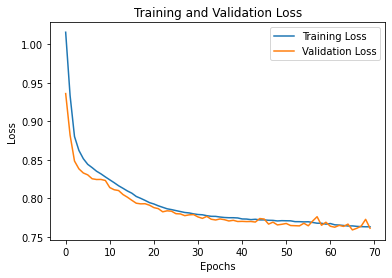

897/897 [==============================] - 1s 1ms/step


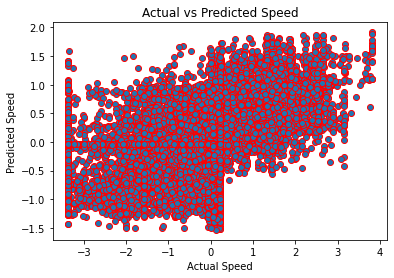

897/897 [==============================] - 1s 1ms/step


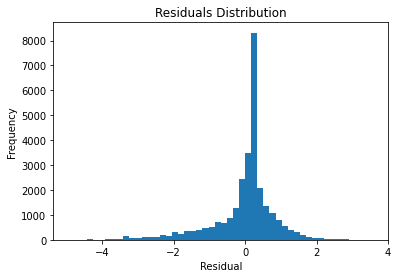

In [27]:
# Plot the training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()



# Plot the actual vs predicted speeds
plt.scatter(y_test, model.predict(X_test), edgecolors='r')
plt.xlabel('Actual Speed')
plt.ylabel('Predicted Speed')
plt.title('Actual vs Predicted Speed')
plt.show()

# Plot the residuals
residuals = y_test - model.predict(X_test)
plt.hist(residuals, bins=50)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Residuals Distribution')
plt.show()